# Bandlimited Angular Spectrum (BLAS)

Example of ["Band-Limited Angular Spectrum Method for Numerical Simulation of Free-Space Propagation in Far and Near Fields"](https://opg.optica.org/oe/fulltext.cfm?uri=oe-17-22-19662&id=186848) (2010) by Matsushima and Shimobaba.

In this example, we replicate Fig 9(a) from the paper, namely propagating a rectangular aperture.

In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

import chromatix.functional as cf

Let's first define the setup as in the paper. We chose the wavelength to be 532 microns. All units are in microns.

In [2]:
shape = (1024, 1024)
N_pad = (512, 512)  # padding to linearize the FFT
spectrum = 0.532  # wavelength
dxi = 2 * spectrum
D = dxi * shape[0]  # field shape
w = D / 2  # width of aperture
z = 100 * D  # propagation distance
dxi = D / np.array(shape)
spacing = dxi[..., np.newaxis]
n = 1  # refractive index of medium
gpu_device = 0

print("Field shape [um]: ", D)
print("Width of aperture [um]: ", w)
print("Propagation distance [um]: ", z)

Field shape [um]:  1089.536
Width of aperture [um]:  544.768
Propagation distance [um]:  108953.6


Let's create a rectangular aperture at the input.

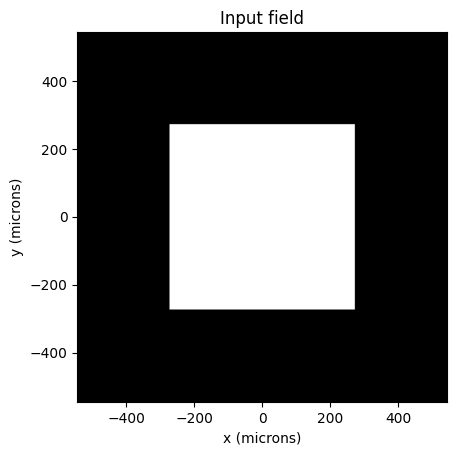

In [3]:
import jax
from jax import device_put

from chromatix.utils import plot_field

field = cf.plane_wave(
    shape=shape,
    dx=spacing,
    spectrum=spectrum,
    spectral_density=1.0,
    pupil=partial(cf.square_pupil, w=w),
)
field = device_put(field, jax.devices()[gpu_device])

ax = plot_field(field)
ax.set_title("Input field")
ax.set_ylabel("y (microns)")
ax.set_xlabel("x (microns)");

And now we propagate! With and without bandlimiting. By default ``bandlimit=False``.

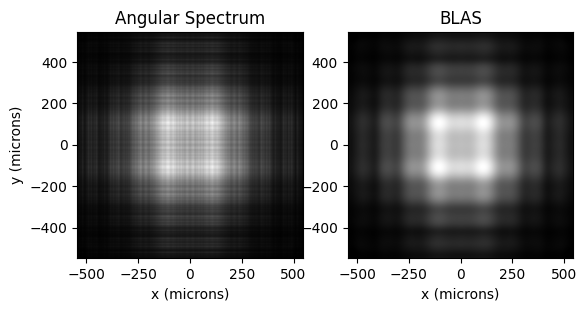

In [4]:
# Angular spectrum
out_field_asm = cf.asm_propagate(field, z, n, N_pad=N_pad, mode="same", bandlimit=False)
u_asm = out_field_asm.amplitude.squeeze()

# Angular spectrum (bandlimited)
out_field_blas = cf.asm_propagate(field, z, n, N_pad=N_pad, mode="same", bandlimit=True)
u_blas = out_field_blas.amplitude.squeeze()

# Plot the results
fig, axs = plt.subplots(1, 2)
plot_field(out_field_asm, ax=axs[0])
axs[0].set_title("Angular Spectrum")
axs[0].set_ylabel("y (microns)")
axs[0].set_xlabel("x (microns)")
plot_field(out_field_blas, ax=axs[1])
axs[1].set_title("BLAS")
axs[1].set_xlabel("x (microns)");

We can observe how bandlimiting removes the high frequency noise due to aliasing.